### Imports

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import pandas as pd
from typing import List
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets


### Constantes

In [ ]:
YEARS = 10
PI = np.pi
DELTA = 1/365

### Funciones utiles

In [ ]:
#para viento promedio
def theta(i):
    """Funcion de tita(i) demuestra la relacion del viento a medida que cambian las estaciones
    """
    return 6 +  2* np.cos(2 * PI * i / 365)

def nextDay_regional(i ,Si ,K ,sigma):
    """Modelo de el viento promedio de la region en cada dia i"""
    return Si + K*(theta(i) - Si) * DELTA + sigma * DELTA**0.5 * np.random.normal(0,1)

def simulateTrip_regional(k , sigma, S0 = 8):
    """Modelado para el viento regional, simula lo que searia tantos años entero de viento"""
    days = np.arange(0, 365 * YEARS, 1)
    shoks = np.random.normal(0, 1, len(days))
    trip = [S0]
    for i in days:
        Si = trip[-1]
        trip.append(nextDay_regional(i,Si, k, sigma))
    return trip

#Para el wind gap
def nextDay_windgap(Di, beta, gamma):
    """Modelo de la diferencia de viento entre el molino norte y sur cada dia i"""
    return Di - beta * Di * DELTA + gamma * DELTA**0.5 * np.random.normal(0,1)

def simulateTrip_windgap(beta, gamma):
    """Modelado para la diferencia de viento entre el molino norte y sur, simula lo que searia tantos años de viento"""
    days = np.arange(0, 365 * YEARS, 1)
    trip = [0]
    for i in days:
        a = nextDay_windgap(trip[-1], beta, gamma)
        trip.append(nextDay_windgap(trip[-1], beta, gamma))
    return trip


# 1

## Estimar viento regional

### Cargamos los datos

In [ ]:
data = pd.read_excel("Wind data for TP1.xlsx")

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


### Constantes

In [117]:
S0 = data["regional wind"][0]
D0 = data["wind gap norte sur"][0]
N = data.shape[0]

### Calculamos la diferencia entre Si+1  - Si

In [118]:
# modelo del molino
# Si+1 = Si + κ(θ(ti) −Si)∆ + σ√∆ Zi (1)
# Si+1  - Si = κ(θ(ti) −Si)∆ + σ√∆ Zi 

In [121]:
# new column with the diff between one day and the previous one
data["diff_regional"] = data["regional wind"].diff().shift(-1)

data.head()

,dia,regional wind,wind gap norte sur,diff_wind
0,1,8.000000,0.000000,0.346296
1,2,8.346296,0.181523,1.716019
2,3,10.062316,0.188643,0.729021
3,4,10.791337,0.071085,-0.037244
4,5,10.754093,0.078442,0.017364


### Regresion Lineal 

In [123]:
# Supongamos que tienes los datos en un DataFrame
# df['S'] es la columna de la variable S
# df['theta'] es la columna de la variable θ(t)
# Δ es el tamaño de paso del tiempo

# Calcular las diferencias Y_i = S_{i+1} - S_i
data['diff_regional'] = data['regional wind'].diff().shift(-1)

# Calcular X1_i = (θ(t_i) - S_i) * Δ
data['X1'] = (theta(data["regional wind"][:-1].index.values) - data["regional wind"][:-1]) * DELTA

# Calcular Z_i como el residuo de Y y X1
# Suponiendo que tienes alguna estimación de Z_i, si no, deberás calcularla
# Z_i es N(0,1) distribuido normalmente, por lo que puedes modelarlo a partir del residuo
# Por simplicidad, puedes asumir que Z_i es un vector aleatorio para fines de regresión.

# Crear el modelo de regresión
X_regional_wind = data[['X1']][1:-1]
Y_regional_wind = data['diff_regional'][1:-1]
print("NULOS:  " + str( X_regional_wind.isnull().sum()))

# Ajustar el modelo de regresión
model = LinearRegression()
model.fit(X_regional_wind, Y_regional_wind)

# Obtener el valor de kappa (pendiente)
kappa = model.coef_[0]

# El valor de sigma puede necesitar un análisis adicional si lo deseas estimar explícitamente
# como sigma * sqrt(Δ). Esto puede derivarse a través de los residuos.

print(f"Valor estimado de kappa: {kappa}")


NULOS:  X1    0
dtype: int64
Valor estimado de kappa: 109.25770145796069


### Calculamos Sigma

In [124]:
# Calcular los residuos de la regresión
error_RW = Y_regional_wind - model.predict(X_regional_wind)
var_RW = error_RW.var()
sigma = np.sqrt(var_RW / DELTA)

print(f"Valor estimado de sigma: {sigma}")

Valor estimado de sigma: 16.047720266718766


### Graficos: Simulacion de viento promedio para ambos molinos

In [125]:
kappa, sigma

(109.25770145796069, 16.047720266718766)

109.25770145796069 16.047720266718766


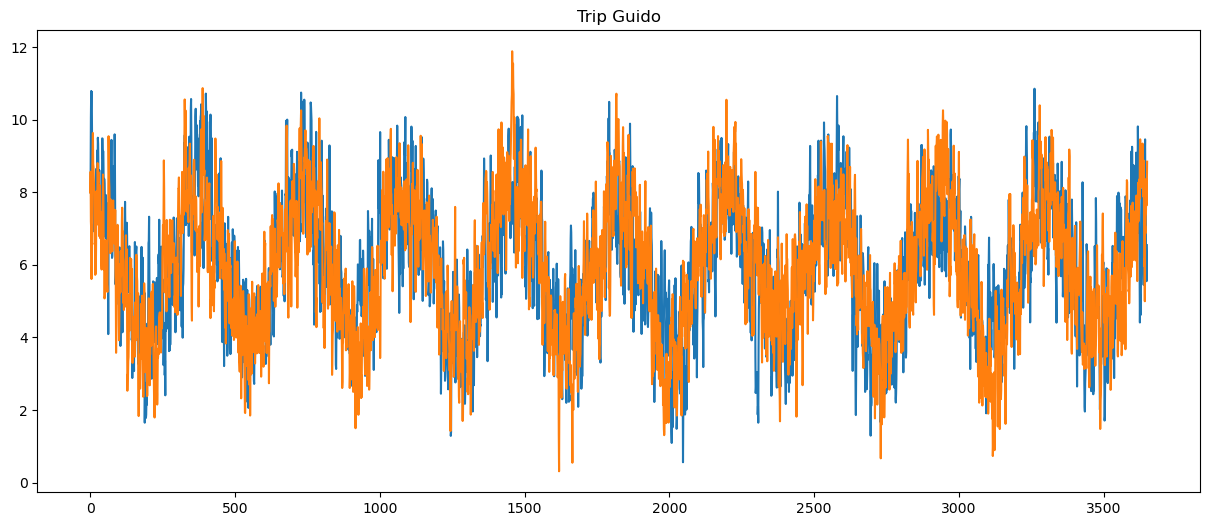

In [126]:
plt.figure(figsize=(15, 6))

# graficar data
plt.plot(data['regional wind'])

# graficar modelo predicgo

print(kappa, sigma)
modelo_viento_promedio = simulateTrip_regional(109, sigma,S0=8)
plt.plot(modelo_viento_promedio)
plt.title("Model Estimation of regional wind beahvior vs. original data")
plt.xlabel("Days")
plt.ylabel("Regional Wind Speed")
plt.show()


### Ver que tan real y fidedigno e el paramtro con medidas de error

## Estimar diferencia entre molinos

### Calculamos la diferencia Di+1 - Di

In [127]:
# new column with the diff between one day and the previous one

data["diff_wind_gap"] = data["wind gap norte sur"].diff().shift(-1)

data.head()

,dia,regional wind,wind gap norte sur,diff_wind,X1,diff_wind_gap
0,1,8.000000,0.000000,0.346296,0.000000,0.181523
1,2,8.346296,0.181523,1.716019,-0.000950,0.007120
2,3,10.062316,0.188643,0.729021,-0.005653,-0.117558
3,4,10.791337,0.071085,-0.037244,-0.007655,0.007358
4,5,10.754093,0.078442,0.017364,-0.007558,0.563745


### Regresion lineal

In [128]:
# Diferencia entre molinos

#Di+1 = Di −βDi∆ + γ√∆ Wi (2)
#Di+1 - Di = βDi∆ + 0 (2)

# Calcular las diferencias Y_i = D_{i+1} - D_i
data['diff_wind_gap'] = data['wind gap norte sur'].diff().shift(-1)

# Calcular X1_i = (-Di) * Δ 
data['X_wind_gap'] = -1 *data["wind gap norte sur"][1:] * DELTA 

# Calcular W_i como el residuo de Y y X1
# Suponiendo que tienes alguna estimación de W_i, si no, deberás calcularla
# W_i es N(0,1) distribuido normalmente, por lo que puedes modelarlo a partir del residuo
# Por simplicidad, puedes asumir que W_i es un vector aleatorio para fines de regresión.

# Crear el modelo de regresión
X_wind_gap = data[['X_wind_gap']][1:-1]
Y_wind_gap = data[['diff_wind_gap']][1:-1]

# Ajustar el modelo de regresión
model = LinearRegression()
model.fit(X_wind_gap, Y_wind_gap)

# Obtener el valor de beta (pendiente)
beta = model.coef_[0][0]


print(f"Valor estimado de beta: {beta}")


[[48.37684938]]
Valor estimado de beta: 48.376849376532675


### Calculamos gamma

In [129]:
# Calcular los residuos de la regresión
error_WG = Y_wind_gap - model.predict(X_wind_gap)
var_WG = error_WG.var()
gamma = np.sqrt(var_WG / DELTA)

print(f"Valor estimado de gamma: {gamma}")

Valor estimado de gamma: 16.047720266718766


### Graficos: Simulacion de diferencia de viente entre ambos molinos

In [130]:
beta, gamma

(48.376849376532675, 16.047720266718766)

48.376849376532675 16.047720266718766


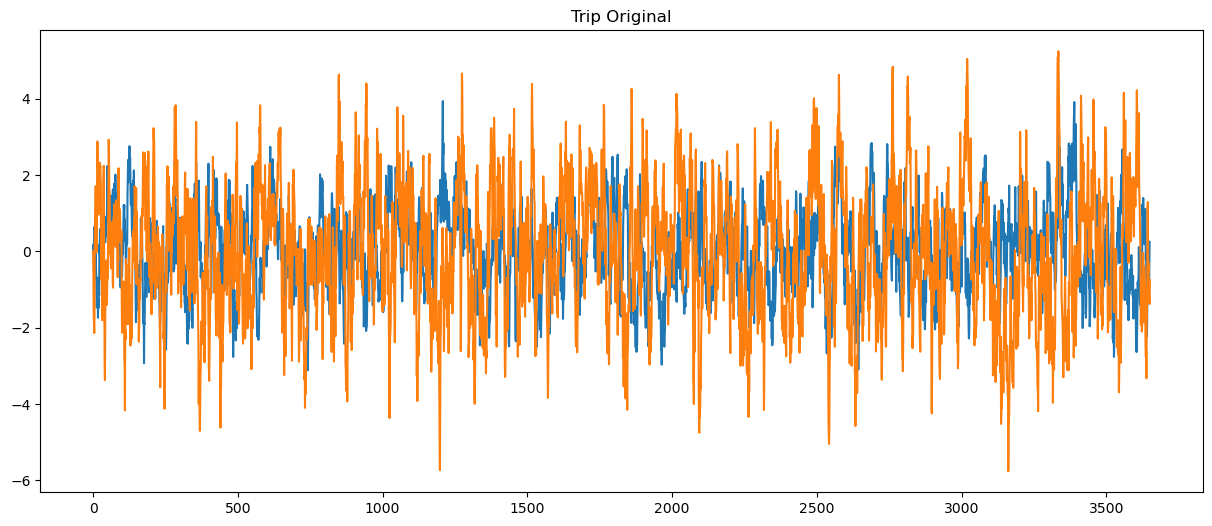

In [131]:
plt.figure(figsize=(15, 6))

# graficar data
plt.plot(data['wind gap norte sur'])


# graficar modelo predicgo
print(beta, gamma)
wind_gap_trip = simulateTrip_windgap(beta, gamma)

plt.plot(wind_gap_trip)
plt.title("Model Estimation of wind gap beahvior vs. original data")
plt.xlabel("Days")
plt.ylabel("Wind Gap")

plt.show()

### Ver que tan real y fidedigno e el paramtro con medidas de error

# 2

## Simulacion simultanea de molinos (norte y sur) con M caminos

In [133]:
def simulacion(kappa, sigma,beta,gamma, dias = N, M = 100):
# m = cantidad de caminos
# simula n dias de los m molinos 
    molinoNorte, molinoSur, diff = np.zeros((M, dias)), np.zeros((M, dias)), np.zeros((M, dias))
    Z,W = np.random.normal(0, 1, (M, dias)), np.random.normal(0, 1, (M, dias))
    
    molinoNorte[:,0] = S0
    diff[:,0] = D0

    for t in range(1, dias):
        molinoNorte[:,t] = molinoNorte[:, t-1] + kappa * (theta(np.zeros(M) + t) - molinoNorte[:, t-1]) * DELTA + np.sqrt(DELTA) * Z[:,t] * sigma
        diff[:,t] = diff[:, t-1] - beta * diff[:, t-1] * DELTA + np.sqrt(DELTA) * W[:,t] * gamma
        molinoSur[:,t] = molinoNorte[:,t] + diff[:,t]
    return molinoNorte , molinoSur   

In [134]:
M = 50
simulations = simulacion(kappa, sigma,beta,gamma,dias= N, M=M)

### Grafico

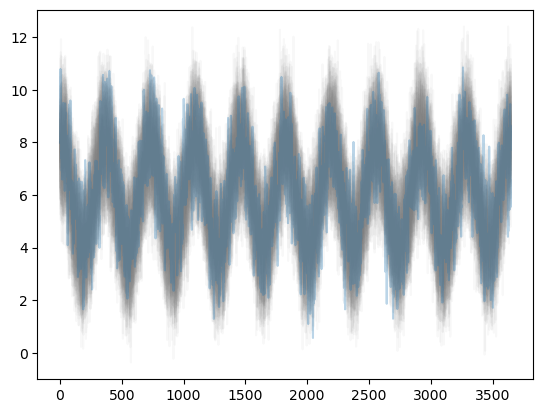

In [135]:
# Plot simulation
for i in range(M):
    # color gray and alpha 0.1
    plt.plot(simulations[0][i,:], color='gray', alpha=0.05)
    #plt.plot(simulations[1][i,:], color='red', alpha=0.005)

plt.plot(data['regional wind'],color="red", alpha=0.3)
plt.title("Simulation of wind for {N} days with {M} roads")
plt.xlabel("Days")
plt.ylabel("Wind Speed")
plt.show()

### Promedio de todos los cmainos para verificar que se acerca a la data historica + error o varianza de este promedio como medidas de seguirdad

## Ganancia con la expecion de roturas y prendido y apagado del molino consideradas

### Constantes

In [136]:
# el ingreso diario generado es 1000 ∗ Si dolares si el molino esta prendido ese dia
PRICE = 1000
# La probabilidad de que el molino se rompa en el dia i, si estaba activo en el dia i −1, es 0.25 ∗ S(i)2∆.
BREAK_PROB = 0.25
# Si el molino falla un dıa, ese dia no estara activo y se arreglara el mismo dıa a un costo de 200 mil dolares
BREAK_COST = 200000
# El acto de apagar el molino cuesta 1000 dolares cada vez. Prenderlo no cuesta nada.
TURN_OFF_COST = 1000
TURN_ON_COST = 0
# La tasa de inter ́es es del 5% anual con capitalizacion diaria (el cashflow en dia i se descuenta como e−0.05i/365)
INTEREST_RATE = 0.05


### Funciones Utiles

In [137]:

def proba_romperse(S):
    return BREAK_PROB * np.array(S) ** 2 * DELTA

def ingreso(S:List[float], isOn:List[bool]):
    return PRICE * np.array(S) * isOn

def nextStateIsOn(S:List[float], isOn:List[bool],k):
    turn_off_candidate = np.array(S) >= k
    prender = ~np.logical_and(isOn , turn_off_candidate)
    apagar = np.logical_and(isOn , turn_off_candidate)

    costo_prender_total = prender * TURN_ON_COST
    costo_apagar_total = apagar * TURN_OFF_COST

    nextIsOn = ~turn_off_candidate
    
    return nextIsOn, costo_prender_total + costo_apagar_total

def seRompio(S:List[float],isOn:List[bool]):
    return np.logical_and(np.random.uniform(0,1,size=(np.array(S).shape)) < p_romperse(S),isOn)



### Probabilidad de romperse

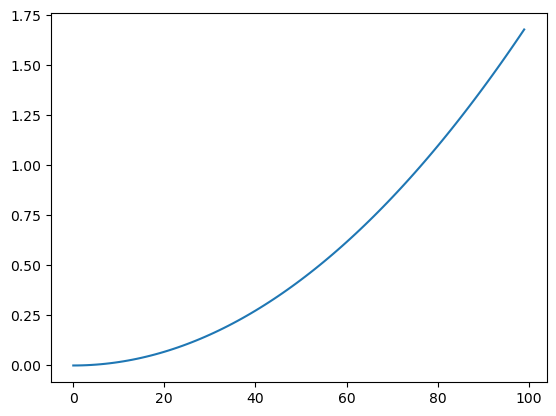

In [138]:
S = np.arange(0,40,0.5)
p = proba_romperse(S)

plt.plot(S,p)
plt.title("Probability of wind turbine breaking")
plt.xlabel("Wind Speed")
plt.ylabel("Probability of breakage")
plt.ylim(0,1.2)
plt.xlim(0,40)
plt.show()

### VAN

In [140]:
def ganancia(molinoNorte, molinoSur,k):
    """ Toma el viento del  del molino norte y del molino sur, 
    calculas sus vientos y ganancias esperadas con las excepeciones 
    de que se rompa el molino o se apague bajo el umbral k. 
    Devuelve las ganancias combinadas 
    """
    isOnNorte = np.zeros(molinoNorte.shape[0]) 
    isOnSur = np.zeros(molinoNorte.shape[0]) 

    gananciaNorte = np.zeros(molinoNorte.shape[0])
    gananciaSur = np.zeros(molinoNorte.shape[0])

    for t in range(molinoNorte.shape[1]):
        gananciaNorte_t = ingreso(molinoNorte[:,t],isOnNorte) - seRompio(molinoNorte[:,t],isOnNorte) * BREAK_COST
        isOnNorte,costosNorte_t = nextStateIsOn(molinoNorte[:,t],isOnNorte,k)
        gananciaNorte += gananciaNorte_t - costosNorte_t

        gananciaSur_t = ingreso(molinoSur[:,t],isOnSur) - seRompio(molinoSur[:,t],isOnSur) * BREAK_COST
        isOnSur,costosSur_t = nextStateIsOn(molinoSur[:,t],isOnSur,k)
        np.append(gananciaSur ,gananciaSur[:,t-1] +  gananciaSur_t - costosSur_t,axis=1)
        
    return gananciaNorte +  gananciaSur

In [145]:
#para cada simulacion calculamos el van osea , recorres cada fila hasta el final?
def van(ganancia):
    """Dada m columnas de simulaciones, recorremos n dias de ganancia y calculamos su VAN
    """
    VAN = np.zeros(ganancia.shape[0])
    for i in range(ganancia.shape[1]):
        VAN += (ganancia[:,i] *(1- np.exp(0.05*i/365))) /(1.05**i)

    return VAN

# 3.

# Nose todavia que es esto


In [141]:
def gananciaV3(molinoNorte, molinoSur,k):

    isOnNorte = np.zeros(molinoNorte.shape[0]) + 1
    isOnSur = np.zeros(molinoNorte.shape[0]) + 1

    gananciaNorte = np.zeros_like(molinoNorte)
    gananciaSur = np.zeros_like(molinoSur)
    

    for t in range(molinoNorte.shape[1]):
        gananciaNorte_t = ingreso(molinoNorte[:,t],isOnNorte) - seRompio(molinoNorte[:,t],isOnNorte) * BREAK_COST
        isOnNorte,costosNorte_t = nextStateIsOn(molinoNorte[:,t],isOnNorte,k)
        gananciaNorte[:,t] = gananciaNorte[:,t-1] +  gananciaNorte_t - costosNorte_t

        gananciaSur_t = ingreso(molinoSur[:,t],isOnSur) - seRompio(molinoSur[:,t],isOnSur) * BREAK_COST
        isOnSur,costosSur_t = nextStateIsOn(molinoSur[:,t],isOnSur,k)
        gananciaSur[:,t] = gananciaSur[:,t-1] +  gananciaSur_t - costosSur_t
        
    return gananciaNorte ,  gananciaSur

In [142]:
def gananciaV4(molinoNorte, molinoSur,k):

    isOnNorte = np.zeros_like(molinoNorte) + 1
    isOnSur = np.zeros_like(molinoNorte) + 1

    gananciaNorte = np.zeros_like(molinoNorte)
    gananciaSur = np.zeros_like(molinoSur)

    roturaNorte = np.zeros_like(molinoNorte)
    roturaSur = np.zeros_like(molinoSur)
    

    for t in range(1,molinoNorte.shape[1]-1):
        isOnNorte[:,t],costosNorte_t = nextStateIsOn(molinoNorte[:,t],isOnNorte[:,t-1],k)
        gananciaNorte_t = ingreso(molinoNorte[:,t],isOnNorte[:,t]) - seRompio(molinoNorte[:,t],isOnNorte[:,t]) * BREAK_COST
        roturaNorte[:,t] = seRompio(molinoNorte[:,t],isOnNorte[:,t])
        
        gananciaNorte[:,t] = gananciaNorte[:,t-1] +  gananciaNorte_t - costosNorte_t

        isOnSur[:,t+1],costosSur_t = nextStateIsOn(molinoSur[:,t],isOnSur[:,t],k)
        gananciaSur_t = ingreso(molinoSur[:,t],isOnSur[:,t]) - seRompio(molinoSur[:,t],isOnSur[:,t]) * BREAK_COST
        roturaSur[:,t] = seRompio(molinoSur[:,t],isOnSur[:,t])
        gananciaSur[:,t] = gananciaSur[:,t-1] +  gananciaSur_t - costosSur_t
        
    return gananciaNorte, gananciaSur,isOnNorte,isOnSur, roturaNorte, roturaSur

In [143]:
simulations = simulacion(kappa, sigma,beta,gamma,dias= 365, M=M)
earningNorte,earningSur = gananciaV3(simulations[0],simulations[1],8)


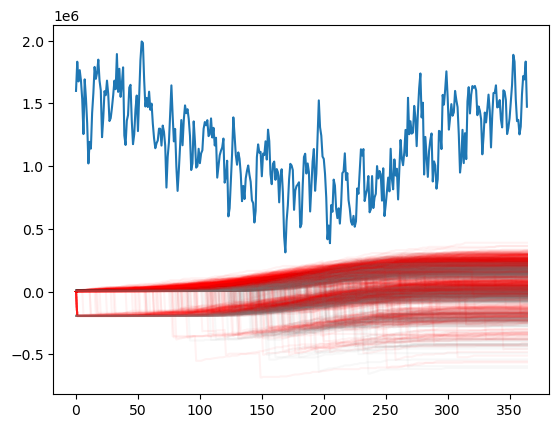

In [144]:
m = 1000
simulations = simulacion(kappa, sigma,beta,gamma,dias= 365, M=m)
earningNorte,earningSur = gananciaV3(simulations[0],simulations[1],4)

# Plot una Ganancia

for i in range(m):
    plt.plot(earningNorte[i,:], color='gray', alpha=0.05)
    plt.plot(earningSur[i,:], color='red', alpha=0.05)

plt.plot(200000*simulations[0][0,:])
plt.show()

In [147]:
# 5000 = 37 seg
# 10000 = 1 min 15 seg
# k = 15
# earnings = [np.mean([np.mean(ganancia(simulations[0],simulations[1],k)) for i in range(5000)]) for k in np.arange(6,11,0.5)]

In [148]:
# plot earnings





In [149]:
m = 1000
n = 365 * 2
K = 10
simulations = simulacion(kappa, sigma,beta,gamma,dias= n, M=m)
gananciaNorte, gananciaSur, isOnNorte,isOnSur, roturaNorte, roturaSur = gananciaV4(simulations[0],simulations[1],5)
gananciaNorteI = [[gananciaV4(simulations[0],simulations[1],k)[0],gananciaV4(simulations[0],simulations[1],k)[2],gananciaV4(simulations[0],simulations[1],k)[3]] for k in np.arange(0,K,1)]

gananciaPromedio = np.array([np.mean(gananciaNorteI[k][0][:,-2]) for k in range(len(gananciaNorteI))])
gananciaVarianza = np.array([np.var(gananciaNorteI[k][0][:,-2]) for k in range(len(gananciaNorteI))])

color = np.array(gananciaNorteI) 

print(gananciaPromedio)
# Plot ganancia (scatter plot)

# Plot una Ganancia
# for i in range(m):
#     plt.plot(gananciaNorte[i,:],color='gray',alpha=0.05)
#     plt.plot(gananciaSur[i,:],color='red',alpha=0.05)

# color dependig if isOn or not
# Scater plot trip



def plot_sine(a):

    color = np.array(1+-(gananciaNorteI[a][1][0,:]) + 2 * gananciaNorteI[a][2][0,:]) 
    # change value 3 to 1 if isOn
    color = np.where(color == 3, 1, color)

    print(color[:100])
    plt.figure(figsize=(10,5))

    plt.scatter(range(simulations[0].shape[1]),simulations[0][0,:],c=color,cmap='coolwarm_r',alpha=0.5)
    # plot threshold k
    plt.axhline(a, color='red')
    plt.show()
    plt.figure(figsize=(10,5))
    for i in range(m-1):
        # plot text
        plt.text(0, 100, "Ganancia del año: " + str(np.mean(gananciaNorteI[a][0][:,-10])), fontsize=12)
        plt.plot(gananciaNorteI[a][0][i,:],color='gray',alpha=0.05)

    plt.show()

    # plot ganancia promedio
    plt.figure(figsize=(10,5))
    plt.plot(gananciaPromedio)
    plt.axvline(a, color='red')
    plt.axhline(0, color='black')
    # plot ganancia promedio + desviacion estandar
    plt.plot(gananciaPromedio + (gananciaVarianza / len(gananciaVarianza))**0.5, color='red',alpha=0.7)
    plt.plot(gananciaPromedio - (gananciaVarianza / len(gananciaVarianza))**0.5, color='red',alpha=0.7)
    plt.plot(gananciaPromedio + (2*gananciaVarianza / len(gananciaVarianza))**0.5, color='red',alpha=0.4)
    plt.plot(gananciaPromedio - (2*gananciaVarianza / len(gananciaVarianza))**0.5, color='red',alpha=0.4)
    plt.show()

    
# Crear un slider interactivo usando ipywidgets

interact(plot_sine, a=widgets.IntSlider(min=0, max=K-1, step= 1, value=8))


ModuleNotFoundError: No module named 'ipywidgets'